In [1]:
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set ERCOT load zone and solar capacity
ERCOT_LOAD_ZONE = 'LZ_HOUSTON'
SOLAR_CAPACITY = 200
SOLAR_PPA_DOL_KWH = 250
FACILITY_LIFETIME = 25

# TODO: update as 'electricity' here is a normalised 8760 solar profile
hourly_dayahead_realtime_solar = pd.read_csv("hourly_dayahead_realtime_solar.csv")

# Filter by load zone and complete data
hourly_dayahead_realtime_solar_lz = hourly_dayahead_realtime_solar[hourly_dayahead_realtime_solar['zone'] == ERCOT_LOAD_ZONE]
hourly_dayahead_realtime_solar_lz = hourly_dayahead_realtime_solar_lz[hourly_dayahead_realtime_solar_lz['electricity'].notna()]

hourly_dayahead_realtime_solar_lz = hourly_dayahead_realtime_solar_lz.iloc[0:24,]
# Sets time duration of the optimisation
# TODO: generat appropriate 8760 - due to shift in UTC time used for solar profile 
# and local_time used for ERCOT realtime and dayahead prices
T = hourly_dayahead_realtime_solar_lz.shape[0]


(CVXPY) Apr 13 08:06:20 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 13 08:06:20 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


/Users/jacklee-kopij/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jacklee-kopij/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/var/folders/y8/n0cwg6hn0xv21zz309nl1hv40000gn/T/ipykernel_11018/704905728.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
  

In [2]:
hourly_dayahead_realtime_solar_lz.head()

,Unnamed: 0,Date,price_dayahead,zone,price_realtime,time,local_time,electricity,Unnamed: 3,Unnamed: 4,...,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
2,2,2019-01-01 00:00:00,20.10,LZ_HOUSTON,14.2075,2019-01-01 06:00,2019-01-01 00:00:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,10,2019-01-01 01:00:00,19.62,LZ_HOUSTON,15.1950,2019-01-01 07:00,2019-01-01 01:00:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,18,2019-01-01 02:00:00,19.21,LZ_HOUSTON,15.5275,2019-01-01 08:00,2019-01-01 02:00:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,26,2019-01-01 03:00:00,18.79,LZ_HOUSTON,16.0575,2019-01-01 09:00,2019-01-01 03:00:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,34,2019-01-01 04:00:00,20.68,LZ_HOUSTON,16.0325,2019-01-01 10:00,2019-01-01 04:00:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Problem 1a: Planning optimisation (optimal electricity consumption)
- First 24 hours of time series only
- Only dayahead market 
- No capex in objective function 
- Annualised CAPEX used (total CAPEX / FACILITY_LIFETIME)
- Sales allowed back into grid from solar
- No fuel cell generating electricity
- A rolling average of 50 tpd of liquid H2 needing to be overtaken
- No offtake constraints

Inputs:
- Dayahead price - ERCOT prices
- Solar price - 250$/mWh
- Solar capacity - 200MW

Decision variables
- Dayahead market consumed 
- Dayahead market supplied
- Electrolyser throttle
- Compressor throttle
- Liquefaction throttle
- Salt dome storage
- LH2 storage
- Nameplate capacity of electrolyser, compressor and liquefaction - no storage

#### Conclusion 
Without addition of CAPEX optimiser will choose to produce all hydrogen in single hour.
In the next problem include CAPEX as a penalty, identify if chooses optimiser chooses to spread production across hours to reduce CAPEX costs i.e. **include CAPEX in objective function**.

In [3]:
import cvxpy as cp
# Set ERCOT load zone and solar capacity
ERCOT_LOAD_ZONE = 'LZ_HOUSTON'
SOLAR_CAPACITY = 200
SOLAR_PPA_DOL_KWH = 250
FACILITY_LIFETIME = 25

# Define decision variables
#   Electricity decision variables
realtime_consumption = cp.Variable(T, nonneg = True)
realtime_supplied = cp.Variable(T, nonneg = True)
solar_consumed_facility = cp.Variable(T, nonneg = True) 

#   Design decision variables
electrolyser_nameplate_capacity_hour = cp.Variable(nonneg = True)
compressor_nameplate_capacity_hour = cp.Variable(nonneg = True)
liquefaction_nameplate_capacity_hour = cp.Variable(nonneg = True)

#   Operational decision variables
electrolyser_throttle = cp.Variable(T)
compression_throttle = cp.Variable(T)
liquefaction_throttle = cp.Variable(T)
gh2_storage_level = cp.Variable(T, nonneg = True)
lh2_storage_level = cp.Variable(T, nonneg = True)

# Define constraints
constraints = [
    1000 <= cp.sum(realtime_consumption) + cp.sum(solar_consumed_facility), 
    # nameplate capacity constraints            
    realtime_consumption <= electrolyser_nameplate_capacity_hour,
    realtime_consumption <= compressor_nameplate_capacity_hour, 
    realtime_consumption <= liquefaction_nameplate_capacity_hour,                      
    solar_consumed_facility <= electrolyser_nameplate_capacity_hour,
    solar_consumed_facility <= compressor_nameplate_capacity_hour, 
    solar_consumed_facility <= liquefaction_nameplate_capacity_hour,
    ]

# Minimize total cost of supply; min(OPEX + CAPEX)
# OPEX = electricity, CAPEX = annualised capex
objective = 0

# add electricity cost from dayahead market consumption
objective += realtime_consumption @ hourly_dayahead_realtime_solar_lz['price_dayahead']

# add electricity cost from solar ppa consumption
objective += cp.sum(SOLAR_PPA_DOL_KWH * solar_consumed_facility)

# Define problem
objective_min = cp.Minimize(objective)
problem = cp.Problem(objective_min, constraints)

# Solve problem
problem.solve()

# Print solution
print("Optimal value:", problem.value)
print("Optimal variable:", realtime_consumption.value)
print(f"solar consumed {solar_consumed_facility.value}")
print(f"Max throughput: {electrolyser_nameplate_capacity_hour.value}")

Optimal value: 18790.000298212603
Optimal variable: [3.58216994e-06 8.98359780e-06 2.79037362e-04 9.99999691e+02
 2.20236509e-06 1.27556517e-06 9.70232106e-07 9.42463333e-07
 8.14481556e-07 8.20261189e-07 7.88109357e-07 6.90435241e-07
 8.11622343e-07 1.04748771e-06 1.06694592e-06 1.12185552e-06
 9.21746178e-07 3.79065834e-07 2.93631407e-07 4.20331917e-07
 4.99855883e-07 6.06870693e-07 7.86768731e-07 9.95384644e-07]
solar consumed [1.39814498e-08 1.39814498e-08 1.39814498e-08 1.39814498e-08
 1.39814498e-08 1.39814498e-08 1.39814498e-08 1.39814498e-08
 1.39814498e-08 1.39814498e-08 1.39814498e-08 1.39814498e-08
 1.39814498e-08 1.39814498e-08 1.39814498e-08 1.39814498e-08
 1.39814498e-08 1.39814498e-08 1.39814498e-08 1.39814498e-08
 1.39814498e-08 1.39814498e-08 1.39814498e-08 1.39814498e-08]
Max throughput: 1066.9835791116748


/Users/jacklee-kopij/opt/anaconda3/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


#### Problem 1b: Planning optimisation (simple)
- Only dayahead market 
- No capex in objective function 
- Annualised CAPEX used (total CAPEX / FACILITY_LIFETIME)
- Sales allowed back into grid from solar
- No fuel cell generating electricity
- A rolling average of 50 tpd of liquid H2 needing to be overtaken
- No offtake constraints

Inputs:
- Dayahead price
- Solar price 

Decision variables
- Dayahead market consumed 
- Dayahead market supplied
- Electrolyser throttle
- Compressor throttle
- Liquefaction throttle
- Salt dome storage
- LH2 storage
- Nameplate capacity of electrolyser, compressor and liquefaction - no storage

###### Conclusion 
Addition of CAPEX in objective function causes moves the optimiser from producing:
- a all production in a single hour (9.99999691e+02) in hour 4 and sizing electrolyser as 1066 ton/hour
instead 
- spreading production across the first 4 hours [2.49997498e+02 2.50000650e+02 2.50000736e+02 2.50000762e+02] and sizing electrolyser to 250 ton/hour

Optimal value: 20180.00000501002
Optimal variable: [2.49999986e+02 2.50000003e+02 2.50000004e+02 2.50000004e+02
 1.81913994e-07 2.48424750e-08 1.62149611e-08 1.53681021e-08
 1.16802770e-08 1.18344317e-08 1.09940930e-08 8.67387192e-09
 1.16045185e-08 1.85441752e-08 1.91141214e-08 2.06736543e-08
 1.47408766e-08 2.48433014e-09 9.72033559e-10 3.19492021e-09
 4.68619505e-09 6.87334625e-09 1.09599589e-08 1.69814830e-08]
solar consumed [8.3104393e-08 8.3104393e-08 8.3104393e-08 8.3104393e-08 8.3104393e-08
 8.3104393e-08 8.3104393e-08 8.3104393e-08 8.3104393e-08 8.3104393e-08
 8.3104393e-08 8.3104393e-08 8.3104393e-08 8.3104393e-08 8.3104393e-08
 8.3104393e-08 8.3104393e-08 8.3104393e-08 8.3104393e-08 8.3104393e-08
 8.3104393e-08 8.3104393e-08 8.3104393e-08 8.3104393e-08]
Max throughput: 250.00000415994154


/Users/jacklee-kopij/opt/anaconda3/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


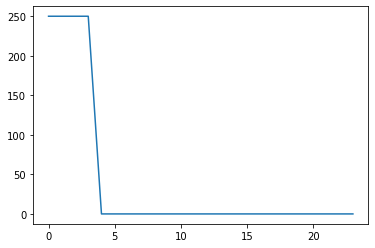

In [3]:
import cvxpy as cp
# Set ERCOT load zone and solar capacity
ERCOT_LOAD_ZONE = 'LZ_HOUSTON'
SOLAR_CAPACITY = 200
SOLAR_PPA_DOL_KWH = 21
FACILITY_LIFETIME = 25

# Define decision variables
#   Electricity decision variables
realtime_consumption = cp.Variable(T, nonneg = True)
realtime_supplied = cp.Variable(T, nonneg = True)
solar_consumed_facility = cp.Variable(T, nonneg = True) 

#   Design decision variables
electrolyser_nameplate_capacity_hour = cp.Variable(nonneg = True)
compressor_nameplate_capacity_hour = cp.Variable(nonneg = True)
liquefaction_nameplate_capacity_hour = cp.Variable(nonneg = True)

#   Operational decision variables
electrolyser_throttle = cp.Variable(T)
compression_throttle = cp.Variable(T)
liquefaction_throttle = cp.Variable(T)
gh2_storage_level = cp.Variable(T, nonneg = True)
lh2_storage_level = cp.Variable(T, nonneg = True)

# Define constraints
constraints = [
    1000 <= cp.sum(realtime_consumption) + cp.sum(solar_consumed_facility), 
    # nameplate capacity constraints            
    realtime_consumption <= electrolyser_nameplate_capacity_hour,
    realtime_consumption <= compressor_nameplate_capacity_hour, 
    realtime_consumption <= liquefaction_nameplate_capacity_hour,                      
    solar_consumed_facility <= electrolyser_nameplate_capacity_hour,
    solar_consumed_facility <= compressor_nameplate_capacity_hour, 
    solar_consumed_facility <= liquefaction_nameplate_capacity_hour,
    ]

# Minimize total cost of supply; min(OPEX + CAPEX)
# OPEX = electricity, CAPEX = annualised capex
objective = 0

# add electricity cost from dayahead market consumption
objective += realtime_consumption @ hourly_dayahead_realtime_solar_lz['price_dayahead']

# add electricity cost from solar ppa consumption
objective += cp.sum(SOLAR_PPA_DOL_KWH * solar_consumed_facility)

# add capex costs for electrolyser, compressor and liquefaction
objective += electrolyser_nameplate_capacity_hour * 1
objective += compressor_nameplate_capacity_hour * 1
objective += liquefaction_nameplate_capacity_hour * 1


# Define problem
objective_min = cp.Minimize(objective)
problem = cp.Problem(objective_min, constraints)

# Solve problem
problem.solve()

# Print solution
print("Optimal value:", problem.value)
print("Optimal variable:", realtime_consumption.value)
print(f"solar consumed {solar_consumed_facility.value}")
print(f"Max throughput: {electrolyser_nameplate_capacity_hour.value}")
plt.plot(realtime_consumption.value)

In [5]:
# add effinciencies 
# ramping constraints 

import cvxpy as cp
# Set ERCOT load zone and solar capacity
ERCOT_LOAD_ZONE = 'LZ_HOUSTON'
SOLAR_CAPACITY = 200
SOLAR_PPA_DOL_KWH = 21
FACILITY_LIFETIME = 25
ELECTROLYSIS_EFFICIENCY = 8
COMPRESSION_EFFICIENCY = 1 
LIQUEFACTION_EFFICIENCY = 1

# Define decision variables
#   Electricity decision variables
realtime_consumption = cp.Variable(T, nonneg = True)
realtime_supplied = cp.Variable(T, nonneg = True)
solar_consumed_facility = cp.Variable(T, nonneg = True) 

#   Design decision variables
electrolyser_nameplate_capacity_hour = cp.Variable(nonneg = True)
compressor_nameplate_capacity_hour = cp.Variable(nonneg = True)
liquefaction_nameplate_capacity_hour = cp.Variable(nonneg = True)

# set throughput
electrolyser_throughput = cp.Variable(T, nonneg = True)
compressor_throughput = cp.Variable(T, nonneg = True)
liquefacion_throughput = cp.Variable(T, nonneg = True)

#   Operational decision variables
electrolyser_throttle = cp.Variable(T)
compression_throttle = cp.Variable(T)
liquefaction_throttle = cp.Variable(T)
gh2_storage_level = cp.Variable(T, nonneg = True)
lh2_storage_level = cp.Variable(T, nonneg = True)

# Define constraints
constraints = [
    1000 <= cp.sum(realtime_consumption) + cp.sum(solar_consumed_facility), 
    # power balance equation: sum of electricity in = amount consumed           
    realtime_consumption + solar_consumed_facility <= 
        ELECTROLYSIS_EFFICIENCY*electrolyser_throughput + 
        COMPRESSION_EFFICIENCY*compressor_throughput + 
        LIQUEFACTION_EFFICIENCY*liquefacion_throughput, 
    # constrain operational bounds of each piece of equipment: 
    0 <= electrolyser_throughput, 
    electrolyser_throughput <= np.repeat([electrolyser_nameplate_capacity_hour], T),
    0 <= compressor_throughput, 
    compressor_throughput <= np.repeat([compressor_nameplate_capacity_hour], T),
    0 <= liquefacion_throughput, 
    liquefacion_throughput <= np.repeat([liquefaction_nameplate_capacity_hour], T)
    ]


# Minimize total cost of supply; min(OPEX + CAPEX)
# OPEX = electricity, CAPEX = annualised capex
objective = 0

# add electricity cost from dayahead market consumption
objective += realtime_consumption @ hourly_dayahead_realtime_solar_lz['price_dayahead']

# add electricity cost from solar ppa consumption
objective += cp.sum(SOLAR_PPA_DOL_KWH * solar_consumed_facility)

# add capex costs for electrolyser, compressor and liquefaction
objective += electrolyser_nameplate_capacity_hour * 1
objective += compressor_nameplate_capacity_hour * 1
objective += liquefaction_nameplate_capacity_hour * 1


# Define problem
objective_min = cp.Minimize(objective)
problem = cp.Problem(objective_min, constraints)

# Solve problem
problem.solve()

# Print solution
print("Optimal value:", problem.value)
print("Optimal variable:", realtime_consumption.value)
print(f"solar consumed {solar_consumed_facility.value}")
print(f"Max throughput: {electrolyser_nameplate_capacity_hour.value}")
plt.plot([realtime_consumption.value, electrolyser_nameplate_capacity_hour.value])


ValueError: setting an array element with a sequence.

In [61]:
hourly_dayahead_realtime_solar_lz['price_dayahead_'] = [round(x) for x in hourly_dayahead_realtime_solar_lz['price_dayahead']]
hourly_dayahead_realtime_solar_lz['price_dayahead'] 

2      20.10
10     19.62
18     19.21
26     18.79
34     20.68
42     22.08
50     23.20
58     23.34
66     24.11
74     24.07
82     24.30
90     25.13
98     24.13
106    22.85
114    22.77
122    22.56
130    23.45
138    30.58
146    34.06
154    29.40
162    27.67
170    26.05
178    24.31
186    23.08
Name: price_dayahead, dtype: float64

In [55]:
test_list= [20,
 20,
 19,
 19,
 21,
 22,
 23,
 23,
 24,
 24,
 24,
 25,
 24,
 23,
 23,
 23,
 23,
 31,
 34,
 29,
 28,
 26,
 24,
 23]